In [ ]:
# Jovian Commit Essentials
# Please retain and execute this cell without modifying the contents for `jovian.commit` to work
!pip install jovian --upgrade -q
import jovian
jovian.set_project('course-project-classification-resnet')
jovian.set_colab_id('1TI5Nv-hHNjBqpcWQYH_WsKhdBpTlzwMq')

In [ ]:
!pip install jovian --upgrade --quiet 

# Intel Image Classification using ResNet in PyTorch 

The ability to try many different neural network architectures to address a problem is what makes deep learning really powerful, especially compared to shallow learning techniques like linear regression, logistic regression, etc. 

**Dataset** - [Intel Image Classification](https://www.kaggle.com/puneet6060/intel-image-classification/version/2)

Created by Intel for an image classification contest, this expansive image dataset contains approximately 25,000 images. Furthermore, the images are divided into the following categories: *buildings, forest, glacier, mountain, sea, and street.*

**Modeling objective** - Here we are using Image dataset for classification problem. 
The task is to classify the given images and train a model to predict any previously unseen images which belongs to one of the classes with maximum accuracy using deep neural network, CNN and ResNets (In this using ResNet9).



**Let's begin by installing and importing the required libraires** 

In [ ]:
# Uncomment and run the appropriate command for your operating system, if required
# No installation is reqiured on Google Colab / Kaggle notebooks

# Linux / Binder / Windows (No GPU)
# !pip install numpy matplotlib torch==1.7.0+cpu torchvision==0.8.1+cpu torchaudio==0.7.0 -f https://download.pytorch.org/whl/torch_stable.html

# Linux / Windows (GPU)
# pip install torch==1.7.1+cu110 torchvision==0.8.2+cu110 torchaudio==0.7.2 -f https://download.pytorch.org/whl/torch_stable.html
 
# MacOS (NO GPU)
# !pip install numpy matplotlib torch torchvision torchaudio

!pip install opendatasets --upgrade

Requirement already up-to-date: opendatasets in /usr/local/lib/python3.6/dist-packages (0.1.10)


In [ ]:
import torch
import os
import torchvision
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.nn.functional as F
from torchvision.datasets import MNIST
from torchvision.datasets import ImageFolder
from torchvision.transforms import ToTensor
from torchvision.utils import make_grid
from torch.utils.data.dataloader import DataLoader
from torch.utils.data import random_split
import seaborn as sns
import opendatasets as od
%matplotlib inline

# Use a white background for matplotlib figures
matplotlib.rcParams['figure.facecolor'] = '#ffffff'

In [ ]:
project_name = "course-project-image-classification"

Now let's download the dataset. Here downloading the dataset with the help ***opendatasets*** library 

In [ ]:
dataset_url = 'https://www.kaggle.com/puneet6060/intel-image-classification/version/2'
od.download(dataset_url)

Please provide your Kaggle credentials to download this dataset. Learn more: http://bit.ly/kaggle-creds
Your Kaggle username: nightsky1598
Your Kaggle Key: ··········


  5%|▍         | 17.0M/346M [00:00<00:01, 175MB/s]

100%|██████████| 346M/346M [00:01<00:00, 222MB/s]


### Exploring the Dataset 

In [ ]:
print(os.listdir('.'))

['.config', 'intel-image-classification', 'sample_data']


In [ ]:
data_dir = './intel-image-classification'
print(os.listdir(data_dir))


['seg_pred', 'seg_train', 'seg_test']


Let's see the total number and types of categories peresent in the dataset.

In [ ]:
classes = os.listdir(data_dir + "/seg_train/seg_train")
print("Total number of categories in dataset is",len(classes))
print("categories in dataset are",classes)

Total number of categories in dataset is 6
categories in dataset are ['mountain', 'sea', 'street', 'buildings', 'glacier', 'forest']


Now Let's check Number of images belonging to each category

In [ ]:
count = []
for folder in classes:
    num_images = len(os.listdir(data_dir + '/seg_train/seg_train/' + folder))
    count.append(num_images)
    print(f'There are {num_images} images present in the {folder} category.')

There are 2512 images present in the mountain category.
There are 2274 images present in the sea category.
There are 2382 images present in the street category.
There are 2191 images present in the buildings category.
There are 2404 images present in the glacier category.
There are 2271 images present in the forest category.


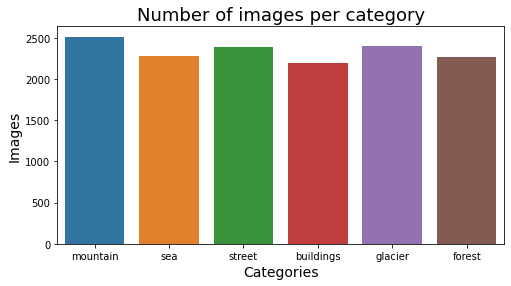

In [ ]:
plt.figure(figsize=(8,4))
sns.barplot(x=classes, y=count)
plt.title('Number of images per category', size=18)
plt.ylabel('Images', size=14)
plt.xlabel('Categories', size=14)
plt.show;

### Data Preparation 

We observed that the number of images in each category is different. but on average it is around 2200 images per class.
To avoid the problem of overfitting we need to transform our data.(Normalization and data augmentation )
1) Resizing data - since all the images in each category is not of same size. so we need to resize all the images.

2) Croping Random 150 x 150 pixel image after applying padding=4 which makes image shape equal to 158 x 158 pixels.

3) Random Data Augmentation - If there's some black portion i.e. portion from padding, we replace those pixels with random Horizontal pixels creating mirror like reflection.

4) converting to tensor fromat

5) Channel wise data normalization - Normalize all values so that they lies in range -1 to 1. Normalizing the data prevents the values from any one channel from disproportionately affecting the losses and gradients while training, simply by having a higher or wider range of values that others.




In [ ]:
import torchvision.transforms as tt
# stats = ((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))
stats = ((0.4300, 0.4571, 0.4533), (0.2581, 0.2563, 0.2886))

train_tt = tt.Compose([
    tt.Resize((130, 130)),
    tt.RandomCrop(130, padding = 4, padding_mode = 'reflect'),
    tt.RandomHorizontalFlip(),
    tt.ToTensor(),
    tt.Normalize(*stats, inplace = True)
])

val_tt = tt.Compose([
    tt.Resize((130, 130)),
    tt.ToTensor(),
    tt.Normalize(*stats)
])

In [ ]:
# Pytorch datasets
train_set = ImageFolder(data_dir+'/seg_train/seg_train', transform=train_tt)
val_set = ImageFolder(data_dir+'/seg_test/seg_test', transform=val_tt)

Note that this dataset consists of 3-channel color images (RGB). Let us look at a sample image from the dataset. matplotlib expects channels to be the last dimension of the image tensors (whereas in PyTorch they are the first dimension)so we'll use the .permute tensor method to shift channels to the last dimension. Let's also print the label for the image.

In [ ]:
def show_example(img, label):
    print(f'Label: {train_set.classes[label]} ({label})')
    print(f'image.shape: {img.shape}')
    plt.imshow(img.permute(1, 2, 0))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Label: buildings (0)
image.shape: torch.Size([3, 130, 130])


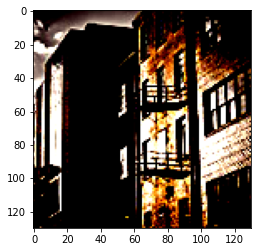

In [ ]:
show_example(*train_set[100])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Label: buildings (0)
image.shape: torch.Size([3, 130, 130])


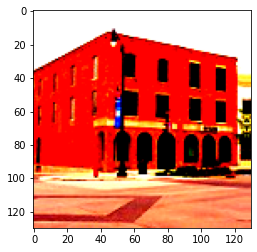

In [ ]:
show_example(*train_set[10])

Next, we can create data loaders to load images in batches to make tranning faster.


In [ ]:
batch_size = 68

In [ ]:
from torch.utils.data import DataLoader

train_dl = DataLoader(train_set, batch_size, shuffle=True, num_workers=4, pin_memory=True)
val_dl = DataLoader(val_set, batch_size*2, num_workers=4, pin_memory=True)

Let's take a look at some sample images from the training dataloader. To display the images, we'll need to denormalize the pixels values to bring them back into the range (0,1).

In [ ]:
def denormalize(imgs, means, stds):
    means = torch.tensor(means).reshape(1,3,1,1)
    stds  = torch.tensor(stds).reshape(1,3,1,1)
    return imgs * stds + means

def show_batch(dl):
    for imgs, labels in dl:
        print(imgs.shape)
        fig, ax = plt.subplots(figsize=(18,9))
        ax.set_xticks([])
        ax.set_yticks([])
        denorm_imgs = denormalize(imgs, *stats)
        plt.imshow(make_grid(denorm_imgs[:64], nrow=8).permute(1,2,0).clamp(0,1))
        break



torch.Size([68, 3, 130, 130])


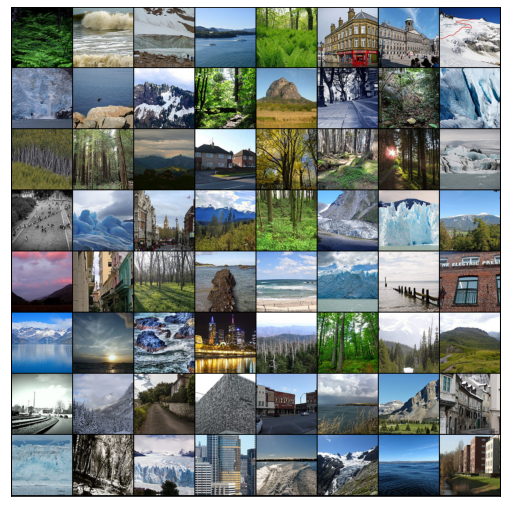

In [ ]:
show_batch(train_dl)

### Using a GPU

As the sizes of our models and datasets increase, we need to use GPUs to train our models within a reasonable amount of time. GPUs contain hundreds of cores optimized for performing expensive matrix operations on floating-point numbers quickly, making them ideal for training deep neural networks. You can use GPUs for free on Google Colab and Kaggle or rent GPU-powered machines on services like Google Cloud Platform, Amazon Web Services, and Paperspace.


We can check if a GPU is available and the required NVIDIA CUDA drivers are installed using torch.cuda.is_available.

In [ ]:
torch.cuda.is_available()

True

Let's define a helper function to ensure that our code uses the GPU if available and defaults to using the CPU if it isn't.

In [ ]:
def get_default_device():
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')
    
def to_device(data, device):
    if isinstance(data, (list, tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

class DeviceDataLoader():
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device
        
    def __iter__(self):
        for b in self.dl:
            yield to_device(b, self.device)
            
    def __len__(self):
        return len(self.dl)

In [ ]:
device = get_default_device()
device

device(type='cuda')

Now we have cuda GPU available to work on. So, we are going to use GPU for better training performance.
let's wrap our training and validation data loaders using DeviceDataLoader for automatically transferring batches of data to the GPU (if available).

In [ ]:
train_dl = DeviceDataLoader(train_dl, device)
val_dl = DeviceDataLoader(val_dl, device)

In [ ]:
jovian.commit(project='project_name') 

[jovian] Detected Colab notebook...
[jovian] Uploading colab notebook to Jovian...
[jovian] Capturing environment..
[jovian] Committed successfully! https://jovian.ai/astha1998/course-project-classification-resnet


'https://jovian.ai/astha1998/course-project-classification-resnet'

## Defining a Model (Network Architecture)
#### Model with Residual blocks and Batch Normalization

One of the applied improvements to the Convolutional Neural Network (CNN) model is the addition of the Residual block, which adds the original input back to the output feature map obtained by passing the input through one or more convolutional layers.

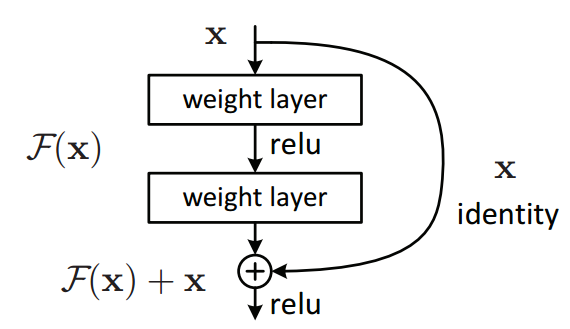




In [ ]:
class SimpleResidualBlock(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=3, kernel_size=3, stride=1, padding=1)
        self.relu1 = nn.ReLU()
        self.conv2 = nn.Conv2d(in_channels=3, out_channels=3, kernel_size=3, stride=1, padding=1)
        self.relu2 = nn.ReLU()
        
    def forward(self, x):
        out = self.conv1(x)
        out = self.relu1(out)
        out = self.conv2(out)
        return self.relu2(out) + x # ReLU can be applied before or after adding the input

In [ ]:
simple_resnet = to_device(SimpleResidualBlock(), device)

for images, labels in train_dl:
    out = simple_resnet(images)
    print(out.shape)
    break
    
del simple_resnet, images, labels
torch.cuda.empty_cache()

torch.Size([68, 3, 130, 130])


Addition of the Residual block produces a significant improvement in the performance of the model. Also, after each convolutional layer, will add a batch normalization layer, which normalizes the outputs of the previous layer.

We will use the ResNet9 architecture -

8 - Convolutional Layers
1 - Linear Layer
8 - ReLU layers
3 - MaxPools Layers
1 - Flatten Layer
1 - Dropout Layer
In ResNets, we add input to the output got after some processing on given input.

Input-> Output + Input

In [ ]:
# Accuracy function which calculated accuracy of prediction.
# A Class ImageClassificationBase which extends nn.Module and has basic model functionality like training, validating, and some metrics like average loss, accuaracy.

def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1)
    return torch.tensor(torch.sum(preds == labels).item() / len(preds))

class ImageClassificationBase(nn.Module):
    def training_step(self, batch):
        imgs, labels = batch 
        out = self(imgs)                  
        loss = F.cross_entropy(out, labels) 
        return loss
    
    def validation_step(self, batch):
        imgs, labels = batch 
        out = self(imgs)                    
        loss = F.cross_entropy(out, labels)   
        acc = accuracy(out, labels)           
        return {'val_loss': loss.detach(), 'val_acc': acc}
        
    def validation_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()   
        batch_accs = [x['val_acc'] for x in outputs]
        epoch_acc = torch.stack(batch_accs).mean()

        return {'val_loss': epoch_loss.item(), 'val_acc': epoch_acc.item()}
    
    def epoch_end(self, epoch, result):
        print(
            "Epoch [{}], last_lr: {:.5f}, train_loss: {:.4f}, val_loss: {:.4f}, val_acc: {:.4f}".format(
                epoch, result['lrs'][-1],
                result['train_loss'],
                result['val_loss'],
                result['val_acc']
            )
        )

In [ ]:
def conv_block(in_c, out, pool=False):
    layers = [
        nn.Conv2d(in_c, out, kernel_size=3, padding=1),
        nn.BatchNorm2d(out),
        nn.ReLU(inplace=True)
    ]
    
    if pool: layers.append(nn.MaxPool2d(2))
    return nn.Sequential(*layers)


class resnet9(ImageClassificationBase):
    def __init__(self, in_c, n_classes):
        super().__init__()
        
        # 3 x 130 x 130
        self.conv1 = conv_block(in_c, 64)  # 64 x 130 x 130
        self.conv2 = conv_block(64, 128, pool=True) # 128 x 65 x 65
        self.res1 = nn.Sequential(
            conv_block(128, 128),
            conv_block(128, 128)        # 128 x 65 x 65
        )
        
        self.conv3 = conv_block(128, 256, pool=True) # 256 x 32 x 32
        self.conv4 = conv_block(256, 512, pool=True) # 512 x 16 x 16
        self.res2 = nn.Sequential(
            conv_block(512, 512),
            conv_block(512, 512)          # 512 x 16 x 16
        )
        
        self.classifier = nn.Sequential(
            nn.MaxPool2d(16),   
            nn.Flatten(),
            nn.Dropout(0.2),
            nn.Linear(512, n_classes)
        )

    def forward(self, xb):
        out = self.conv1(xb)
        out = self.conv2(out)
        out = self.res1(out) + out
        out = self.conv3(out)
        out = self.conv4(out)
        out = self.res2(out) + out
        out = self.classifier(out)
        return out

In [ ]:
# Shifting our model to GPU RAM

model = to_device(resnet9(3, 6), device)
model

resnet9(
  (conv1): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
  )
  (conv2): Sequential(
    (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (res1): Sequential(
    (0): Sequential(
      (0): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
    )
    (1): Sequential(
      (0): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=Tr

### Training the Model 

Before we train the model, we're going to make a bunch of small but important improvements to our fit function:

 1) **Learning rate scheduling**: Instead of using a fixed learning rate, we will   use a learning rate scheduler, which will change the learning rate after every batch of training. There are many strategies for varying the learning rate during training, and the one we'll use is called the "One Cycle Learning Rate Policy", which involves starting with a low learning rate, gradually increasing it batch-by-batch to a high learning rate for about 30% of epochs, then gradually decreasing it to a very low value for the remaining epochs.

 Learn more: https://sgugger.github.io/the-1cycle-policy.html

2) **Weight decay**: We also use weight decay, which is yet another regularization technique which prevents the weights from becoming too large by adding an additional term to the loss function.

Learn more: https://towardsdatascience.com/this-thing-called-weight-decay-a7cd4bcfccab

3) **Gradient clipping**: Apart from the layer weights and outputs, it also helpful to limit the values of gradients to a small range to prevent undesirable changes in parameters due to large gradient values. This simple yet effective technique is called gradient clipping. 

Learn more: https://towardsdatascience.com/what-is-gradient-clipping-b8e815cdfb48

Let's define a fit_one_cycle function to incorporate these changes. We'll also record the learning rate used for each batch.

In [ ]:
@torch.no_grad()
def evaluate(model, val_dl):
    """ This function evaluated loss and accuracy on validation set """
    model.eval()
    outs = [model.validation_step(x) for x in val_dl]
    return model.validation_epoch_end(outs)

def get_lr(opt):
    """ Returns 'lr' for current epoch """
    for param_group in opt.param_groups:
        return param_group['lr']

def fit_one_cycle(epochs, max_lr, model, train_dl, val_dl,
                  weight_decay=0, grad_clip=None, opt_func=torch.optim.SGD):
    
    """ This is main function which deals with training model on our data """
    torch.cuda.empty_cache()
    history = []
    
    opt = opt_func(model.parameters(), max_lr, weight_decay = weight_decay)
    sched = torch.optim.lr_scheduler.OneCycleLR(opt, max_lr, epochs=epochs,
                                               steps_per_epoch=len(train_dl))
    
    for epoch in range(epochs):
        model.train()
        train_losses = []
        lrs = []
        
        for batch in train_dl:
            # Training step
            loss = model.training_step(batch)
            train_losses.append(loss)
            loss.backward()
            
            if grad_clip:
                nn.utils.clip_grad_value_(model.parameters(), grad_clip)
                
            opt.step()
            opt.zero_grad()
            
            lrs.append(get_lr(opt))
            sched.step()
            
        # Validation step
        result = evaluate(model, val_dl)
        result['train_loss'] = torch.stack(train_losses).mean().item()
        result['lrs'] = lrs
        model.epoch_end(epoch+1, result)
        history.append(result)
        
    return history

In [ ]:
history = [evaluate(model, val_dl)]
history

[{'val_acc': 0.1767902821302414, 'val_loss': 1.7914412021636963}]

When evaluated on validation set first time without training, we get accuracy = 0.1767 i.e. 17.67 % which is fair since there are 6 classes and probability of choosing one is equal to about 16 %. Since, all parameters are initialized randomly we can expect such behaviour. After training our model we can see rise in accuracy value.

We're now ready to train our model. Instead of SGD (stochastic gradient descent), we'll use the Adam optimizer which uses techniques like momentum and adaptive learning rates for faster training. 

Optimizers Reference: https://ruder.io/optimizing-gradient-descent/index.html

In [ ]:
# Setting metrics to be used

epochs = 8
max_lr = 0.01
grad_clip = 0.1
weight_decay = 1e-4
opt_func = torch.optim.Adam

In [ ]:
%%time
history += fit_one_cycle(epochs, max_lr, model, train_dl, val_dl, 
                             grad_clip=grad_clip, 
                             weight_decay=weight_decay, 
                             opt_func=opt_func)

Epoch [1], last_lr: 0.00394, train_loss: 1.0352, val_loss: 2.3174, val_acc: 0.3683
Epoch [2], last_lr: 0.00935, train_loss: 0.9186, val_loss: 0.8726, val_acc: 0.7174
Epoch [3], last_lr: 0.00972, train_loss: 0.7193, val_loss: 0.6012, val_acc: 0.8034
Epoch [4], last_lr: 0.00812, train_loss: 0.5652, val_loss: 0.7719, val_acc: 0.7343
Epoch [5], last_lr: 0.00556, train_loss: 0.4733, val_loss: 0.4599, val_acc: 0.8350
Epoch [6], last_lr: 0.00283, train_loss: 0.3732, val_loss: 0.3607, val_acc: 0.8776
Epoch [7], last_lr: 0.00077, train_loss: 0.3056, val_loss: 0.3081, val_acc: 0.8971
Epoch [8], last_lr: 0.00000, train_loss: 0.2561, val_loss: 0.2967, val_acc: 0.9012
CPU times: user 7min 50s, sys: 7min 29s, total: 15min 19s
Wall time: 15min 44s


In [ ]:
# Total time spent by model in training

train_time = '15:44'

Here, we got maximum accuracy of 90.12 % in 15 minutes after 8 epochs.





#### Let's plot the valdation set accuracies to study how the model improves over time.


In [ ]:
def plot_accuracies(history):
    accuracies = [x['val_acc'] for x in history]
    plt.plot(accuracies, '-x')
    plt.xlabel('epoch')
    plt.ylabel('accuracy')
    plt.title('Accuracy vs. No. of epochs');
    
def plot_losses(history):
    train_losses = [x.get('train_loss') for x in history]
    val_losses = [x['val_loss'] for x in history]
    plt.plot(train_losses, '-bx')
    plt.plot(val_losses, '-rx')
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.legend(['Training', 'Validation'])
    plt.title('Loss vs. No. of epochs');
    
def plot_lrs(history):
    lrs = np.concatenate([x.get('lrs', []) for x in history])
    plt.plot(lrs)
    plt.xlabel('Batch no.')
    plt.ylabel('Learning rate')
    plt.title('Learning Rate vs. Batch no.');

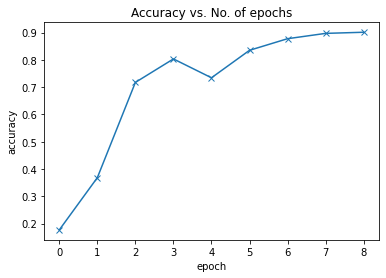

In [ ]:
plot_accuracies(history)

we can see in the graph, the accuracy of the model increases at every epoch except at some point.

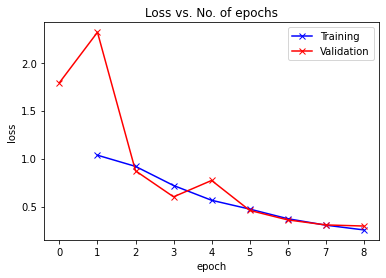

In [ ]:
plot_losses(history)

Objective of this model was to avoid overfitting and It's clear from the trend that our model isn't overfitting to the training data just yet.. Training loss and Validation loss both seems at same level. In overfitting, validation loss would have increased after some epoch but training loss would still be decreasing.

Finally, let's visualize how the learning rate changed over time, batch-by-batch over all the epochs.



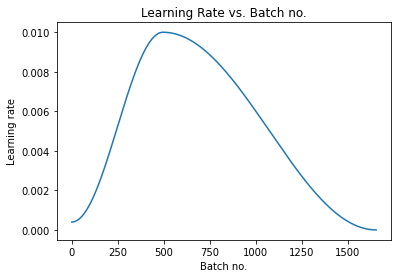

In [ ]:
plot_lrs(history)


As expected, the learning rate starts at a low value, and gradually increases for 30% of the iterations to a maximum value of 0.01, and then gradually decreases to a very small value.

### Testing with individual images

While we have been tracking the overall accuracy of a model so far, it's also a good idea to look at model's results on some sample images. Let's test out our model with some images from the predefined test dataset 

In [ ]:
def denormalize_image(img, means, stds):
    means = torch.tensor(means).reshape(3, 1, 1)
    stds = torch.tensor(stds).reshape(3, 1, 1)
    return img * stds + means

def predict_image(img, model):
    xb = to_device(img.unsqueeze(0), device)
    yb = model(xb)
    _, preds  = torch.max(yb, dim=1)
    return train_set.classes[preds[0].item()]

Label: buildings , Predicted: buildings


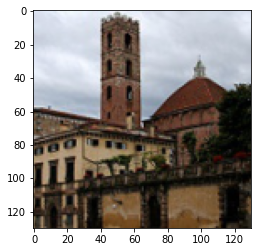

In [ ]:
img, label = val_set[2]
plt.imshow(denormalize_image(img, *stats).permute(1, 2, 0).clamp(0, 1))
print('Label:', train_set.classes[label], ', Predicted:', predict_image(img, model))

Label: glacier , Predicted: glacier


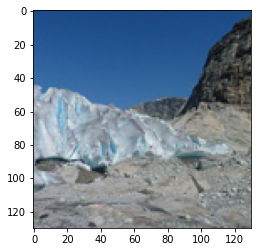

In [ ]:
img, label = val_set[1200]
plt.imshow(denormalize_image(img, *stats).permute(1, 2, 0).clamp(0, 1))
print('Label:', train_set.classes[label], ', Predicted:', predict_image(img, model))

Label: sea , Predicted: sea


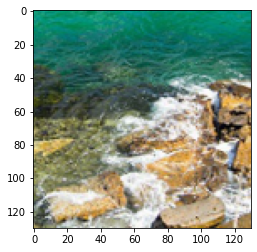

In [ ]:
img, label = val_set[2190]
plt.imshow(denormalize_image(img, *stats).permute(1, 2, 0).clamp(0, 1))
print('Label:', train_set.classes[label], ', Predicted:', predict_image(img, model))

Label: sea , Predicted: sea


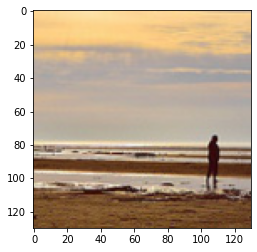

In [ ]:
img, label = val_set[2175]
plt.imshow(denormalize_image(img, *stats).permute(1, 2, 0).clamp(0, 1))
print('Label:', train_set.classes[label], ', Predicted:', predict_image(img, model))

Label: glacier , Predicted: mountain


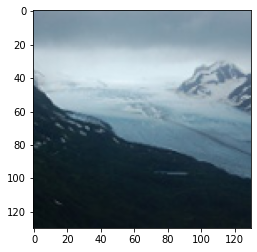

In [ ]:
img, label = val_set[1001]
plt.imshow(denormalize_image(img, *stats).permute(1, 2, 0).clamp(0, 1))
print('Label:', train_set.classes[label], ', Predicted:', predict_image(img, model))

Seems like our model is doing pretty good on test images. That's what our objective was ! Identifying where our model performs poorly can help us improve the model, by collecting more training data, increasing/decreasing the complexity of the model, and changing the hypeparameters.


Let's save the weights of the model and record the hyperparameters. As you try different ideas, make sure to record every experiment so you can look back and analyze the results.

In [ ]:
torch.save(model.state_dict(), 'course-project-image-classification')

In [ ]:
jovian.reset()
jovian.log_hyperparams(arch='resnet9', 
                       epochs=epochs, 
                       lr=max_lr, 
                       scheduler='one-cycle', 
                       weight_decay=weight_decay, 
                       grad_clip=grad_clip,
                       opt=opt_func.__name__)

[jovian] Hyperparams logged.


In [ ]:
jovian.log_metrics(val_loss=history[-1]['val_loss'], 
                   val_acc=history[-1]['val_acc'],
                   train_loss=history[-1]['train_loss'],
                   time=train_time)

[jovian] Metrics logged.


In [ ]:
jovian.commit(project='project_name') 

[jovian] Detected Colab notebook...
[jovian] Please enter your API key ( from https://jovian.ai/ ):
API KEY: ··········
[jovian] Uploading colab notebook to Jovian...
[jovian] Capturing environment..
[jovian] Committed successfully! https://jovian.ai/astha1998/project-name


'https://jovian.ai/astha1998/project-name'

### Conclusion 

In this notebook we designed and trained deep learning model(CNN and ResNet) to achieve over 90% accuracy in classifying images from the Intel dataset:

Here's a summary of the different techniques used in this tutorial to improve our model performance and reduce the training time:
 
**Data normalization**: We normalized the image tensors by subtracting the mean and dividing by the standard deviation of pixels across each channel. Normalizing the data prevents the pixel values from any one channel from disproportionately affecting the losses and gradients.

Reference: https://medium.com/@ml_kid/what-is-transform-and-transform-normalize-lesson-4-neural-networks-in-pytorch-ca97842336bd

**Data augmentation**: We applied random transformations while loading images from the training dataset. Specifically, we will pad each image by 4 pixels, and then take a random crop of size 32 x 32 pixels, and then flip the image horizontally with a 50% probability.

Reference: https://www.analyticsvidhya.com/blog/2019/12/image-augmentation-deep-learning-pytorch/


**Residual Connections**: One of the key area of improvements to my ResNet9 model was the addition of the resudial block, which adds the original input back to the output feature map obtained by passing the input through one or more convolutional layers. I utilized the ResNet9 architecture to that aim.

Reference: https://towardsdatascience.com/residual-blocks-building-blocks-of-resnet-fd90ca15d6ec

**Learning Rate Scheduling**: Instead of using a fixed learning rate, I used a Learning Rate Scheduler, which will change the learning rate after every batch of training. There are many strategies for varying the learning rate during training, and I used the "One Cycle Learning Rate Policy".

Reference: https://sgugger.github.io/the-1cycle-policy.html

**Weight Decay**: I added Weight Decay to the optimizer, yet another regularization technique which prevents the weights from becoming too large by adding an additional term to the loss function.

Reference: https://towardsdatascience.com/this-thing-called-weight-decay-a7cd4bcfccab

**Gradient Clipping**: Moreover, I added Gradient Clipping capability, which helps limit the values of gradients to a small range to prevent undesirable changes in model parameters owing to large gradient values during training.

Reference: https://towardsdatascience.com/what-is-gradient-clipping-b8e815cdfb48#63e0

**Adam Optimizer**: Instead of SGD (Stochastic Gradient Descent), I made use of the Adam optimizer which leverages techniques such as momentum and adaptive learning rates for faster training. There are many other optimizers to choose from and experiment with.

Reference: https://ruder.io/optimizing-gradient-descent/index.html

As future work, will try applying each technique independently and see how much each one affects the performance and training time.